# Fréquence de mise à jour nécessaire

Nous pouvons dès à présent établir un système nous indiquant quand la fréquence de mise à jour nécessaire et idéale des clusters. Il suffit de mettre en place un système d'Ajusted Rand Score avec les clusters KMeans.

Commençons en chargeant notre CSV et en faisant nos imports :

In [3]:
import warnings

import pandas
from sklearn.preprocessing import StandardScaler
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import date, timedelta
from sklearn.metrics.cluster import adjusted_rand_score 
import matplotlib.pyplot as plt

data = pandas.read_csv("data/frequency_rfm.csv")
data = data[["order_id", "price", "freight_value", "customer_id", "order_purchase_timestamp"]]


On va faire une RFM sur nos données comme nous avions déjà pu le faire sur le notebook "clustering".

In [4]:
data = data.groupby('customer_id').agg({"order_purchase_timestamp": "max","order_id": "count", "price": "sum"})
rfm_df = data.copy() 
rfm_df['order_purchase_timestamp'] = pd.to_datetime(rfm_df['order_purchase_timestamp'])

data.rename(columns={'order_purchase_timestamp': 'recency',
                     'order_id': 'frequency',
                     'price': 'monetary_value'
                     }, inplace=True)

data['recency'] = pd.to_datetime(data['recency'])
data['recency'] = (data['recency'].max() - data['recency']).dt.days 

min_date = data['recency'].min()
max_date = data['recency'].max()
delta_date = (max_date - min_date) 

df_kmeans = data.drop(columns=['recency'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans) 

Maintenant que nous avons un modèle kmean entrainé, nous pouvons créer une fonction qui fera le RFM de manière automatique sur chaque période de 15 jours.

In [5]:
def make_rfm(df):
    features = ['recency', 'frequency', 'monetary_value']

    df_test = df.groupby('customer_id').\
    agg({"order_purchase_timestamp": "max",
                                                    "order_id": "count",
                                                    "price" :  "sum",
                                                    })

    df_test.rename(columns={'order_purchase_timestamp': 'recency',
                            'order_id': 'frequency',
                            'price': 'monetary_value'
                            }, inplace=True)
    df_test['recency'] = (df_test['recency'].max() - df_test['recency']).dt.days

    return df_test[features] 

Nous pouvons à présent sortir un dataset global à jour 0 (M0). Il servira principalement en cas de résultat biaisé comme point de comparaison. 

In [6]:
date = datetime.datetime(2018,1,1,0,0,0)
df_final = rfm_df[rfm_df['order_purchase_timestamp'] < date]

df_m0 = make_rfm(df_final)

X_old = df_m0
X_old = StandardScaler().fit_transform(X_old)

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans_old = kmeans.fit(X_old)

Nous avons ainsi un KMean entrainé sur les données à M0, nous pouvons faire le même travail pour M1 (+7j)

In [7]:
date_1 = datetime.datetime(2018,1,7,0,0,0)
df_m1 = make_rfm(rfm_df[rfm_df['order_purchase_timestamp'] < date_1])

X_old_1 = df_m1
X_old_1 = StandardScaler().fit_transform(X_old_1)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans_old1 = kmeans.fit(X_old_1) 

M0 et M1 étant prêt, nous pouvons lancer une ARI en avançant à chaque fois de 7 jours du 1 janvier 2018 au 30 juillet 2018

In [8]:
ari_liste = []
days = []
start_date = datetime.datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime.datetime(2018, 8, 1, 0, 0, 0)
delta = timedelta(days=7) 

while start_date <= end_date:
    print(start_date)
    df_test = rfm_df[rfm_df['order_purchase_timestamp'] < start_date]
    days.append(start_date)
    start_date += delta
    df_visu = make_rfm(df_test)
    X_old_1 = df_visu
    X_old_1 = StandardScaler().fit_transform(X_old_1)
    kmeans_1 = KMeans(n_clusters=4, init='k-means++', random_state=0)
    kmeans_old_1 = kmeans_1.fit(X_old_1)
    labels = kmeans.predict(X_old_1)
    labels_true = kmeans_old_1.labels_

    ari_liste.append(adjusted_rand_score(labels_true, labels))

2018-01-01 00:00:00
2018-01-08 00:00:00
2018-01-15 00:00:00
2018-01-22 00:00:00
2018-01-29 00:00:00
2018-02-05 00:00:00
2018-02-12 00:00:00
2018-02-19 00:00:00
2018-02-26 00:00:00
2018-03-05 00:00:00
2018-03-12 00:00:00
2018-03-19 00:00:00
2018-03-26 00:00:00
2018-04-02 00:00:00
2018-04-09 00:00:00
2018-04-16 00:00:00
2018-04-23 00:00:00
2018-04-30 00:00:00
2018-05-07 00:00:00
2018-05-14 00:00:00
2018-05-21 00:00:00
2018-05-28 00:00:00
2018-06-04 00:00:00
2018-06-11 00:00:00
2018-06-18 00:00:00
2018-06-25 00:00:00
2018-07-02 00:00:00
2018-07-09 00:00:00
2018-07-16 00:00:00
2018-07-23 00:00:00
2018-07-30 00:00:00


Nous devrions avoir une liste d'ARI correspondant à chaque période (de 7 jours).

Affichons à présent un graphique pour les visualiser :

(0.8793999990827502, 1.005738961554272)

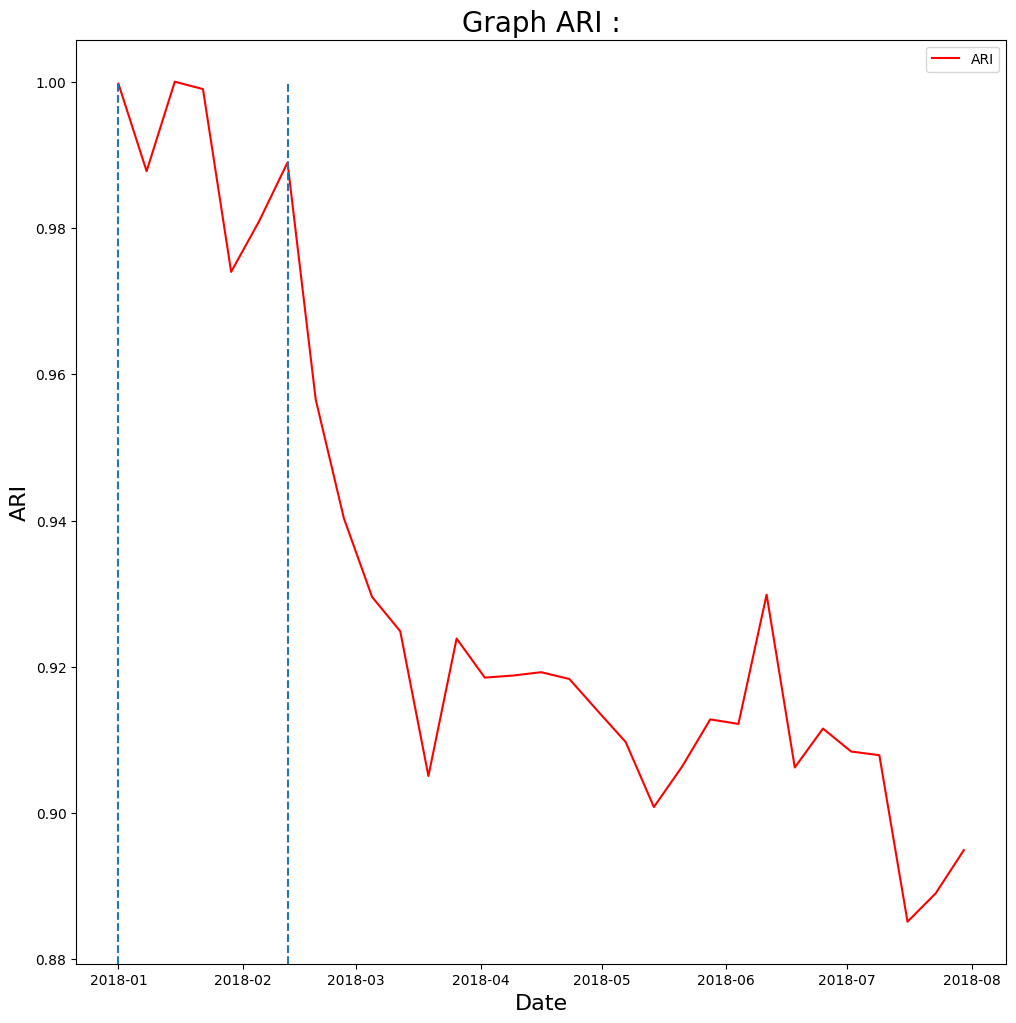

In [9]:
plt.figure(figsize=(12,12))
plt.xlabel('Date',size=16)
plt.ylabel('ARI',size=16)
plt.title('Graph ARI :',size=20)
start = datetime.date(2018,1,1)
final = datetime.date(2018,2,12)

ax = sns.lineplot(x=days, y=ari_liste, color='red', label='ARI')

ylims = ax.get_ylim()

st = ax.vlines(start, ylims[0], ari_liste[0], linestyles='--')
end = ax.vlines(final, ylims[0], ari_liste[0], linestyles='--')

ax.set_ylim(ylims)


# Conclusion



D'après le score ARI sur les périodes, nous pouvons conclure que le modèle devrait être mis à jour environ tout les 45 jours pour garder une bonne qualité.